# Lab 04: Naive Bayes

Trong bài tập này, chúng ta sẽ xây dựng một mô hình dự đoán đội chiến thắng trong một trận đấu Liên Minh Huyền Thoại.

Về cơ bản, Liên Minh Huyền Thoại là một game giữa hai đội Blue và Red với mục tiêu là phá hủy nhà chính đối phương. Mỗi đội có 5 người chơi, mỗi người điều khiển 1 nhân vật. Trong trò chơi, để chiến thắng người chơi có thể:
- Hạ gục đối phương: thể hiện bằng chỉ số hạ gục (Kills)
- Hạ gục lính kiếm tiền mua trang bị (MinionsKilled)
- Cắm mắt để có tầm nhìn, thêm thông tin về đối phương (WardsPlaced)
- Ăn sứ giả lấy bùa và vật phẩm (Heralds)
- Ăn bùa rồng (Dragons)

## Data

Dựa vào các thông tin trong 10 phút đầu của trận đấu
- killsDiff: số mạng hạ gục chênh lêch giữa đội Blue và Red, số nguyên
- minionsKilledDiff: số lính hạ gục chênh lêch giữa đội Blue và Red, số nguyên
- wardPlacedDiff: số mắt đã cắm chênh lêch giữa đội Blue và Red, số nguyên
- firstBlood: đội nào có mạng hạ gục đầu tiên, category: blue hoặc red
- heralds: đội nào hạ gục heralds, category: none, blue hoặc red
- dragons: đội nào hạ gục dragons, category: none, blue hoặc red

Hãy dự đoán đội nào chiến thắng: blue hay red

In [1]:
import pandas as pd
df = pd.read_csv("lienminh.csv")
df.head()

,killsDiff,minionsKilledDiff,wardPlacedDiff,firstBlood,heralds,dragons,teamWins
0,3,-2,13,blue,none,none,red
1,0,-66,0,red,red,red,red
2,-4,-17,0,red,none,blue,red
3,-1,-34,28,red,blue,none,red
4,0,-15,58,red,none,red,red


In [2]:
killsDiff = df['killsDiff'].values
minionsKilledDiff = df['minionsKilledDiff'].values
wardPlacedDiff = df['wardPlacedDiff'].values
firstBlood = df['firstBlood'].values
heralds = df['heralds'].values
dragons = df['dragons'].values

teamWins = df['teamWins'].values

### Analyse xíu

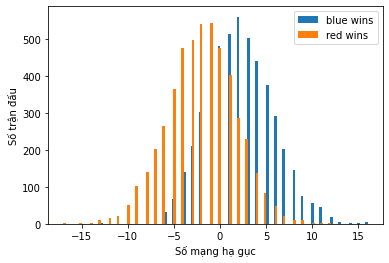

In [3]:
import matplotlib.pyplot as plt
## vẽ histogram (phân phối) của chênh lệch mạng hạ gục khi từng đội thắng
_ = plt.hist(killsDiff[teamWins=='blue'], bins=100, label='blue wins')
_ = plt.hist(killsDiff[teamWins=='red'], bins=100, label='red wins')
plt.xlabel("Số mạng hạ gục")
plt.ylabel("Số trận đấu")
plt.legend()
plt.show()

In [4]:
import numpy as np
# tính tương quan tuyến tính (correlation coefficient) giữa  việc hạ gục mạng đầu và chiến thắng
np.corrcoef((firstBlood == 'blue').astype(int), (teamWins == 'blue').astype(int))

array([[1.        , 0.20176926],
       [0.20176926, 1.        ]])

## Categorical Naive Bayes

Gọi $X$ là một biến thể hiện đội nào có mạng hạ gục đầu tiên, $X$ có không gian mẫu hữu hạn $\Omega = \{blue, red\}$. Ta muốn đoán xem đội nào thắng dựa vào $X$ bằng cách tính $P(B|X)$ và $P(R|X)$, với $B$ và $R$ lần lượt là biến cố blue và red thắng. Ta giả thuyết
$$ P(B|X) = \frac{P(X|B)P(B)}{P(X|B)P(B) + P(X|R)P(R)}, P(R|X) = 1 - P(B|X).$$
$P(B)$ và $P(R)$ là xác suất tiên nghiệm, ta xem như hai tỉ lệ hai đội thắng bằng nhau. 

Giờ chỉ cần tính $P(X|B)$ và $P(X|R)$.

In [5]:
## xác suất tiên nghiệm
P_blueWins = 0.5
P_redWins = 0.5

In [6]:
is_bluefirstBlood = (firstBlood == 'blue').astype(float)

## tính P(X|B)
P_blueFirstBlood_blueWins  = np.sum(firstBlood[teamWins == 'blue'] == 'blue') / np.sum(teamWins == 'blue')
P_blueFirstBlood_blueWins = P_blueFirstBlood_blueWins * is_bluefirstBlood + (1-P_blueFirstBlood_blueWins)*(1-is_bluefirstBlood)
P_redFirstBlood_blueWins = 1 - P_blueFirstBlood_blueWins

## tính P(X|R)
P_blueFirstBlood_redWins = np.sum(firstBlood[teamWins == 'red'] == 'blue') / np.sum(teamWins == 'red')
P_blueFirstBlood_redWins = P_blueFirstBlood_redWins * is_bluefirstBlood + (1-P_blueFirstBlood_redWins)*(1-is_bluefirstBlood)

In [7]:
## P(B|X)
P_blueWins_blueFirstBlood = P_blueFirstBlood_blueWins * P_blueWins / (P_blueFirstBlood_blueWins * P_blueWins + P_blueFirstBlood_redWins * P_redWins)
acc = np.mean((P_blueWins_blueFirstBlood > 0.5) == (teamWins == 'blue'))
print(acc)

0.6008705334548031


In [8]:
## Dùng sklearn
from sklearn.naive_bayes import CategoricalNB
blueFirstBlood_float = (firstBlood.reshape(-1,1) == 'blue').astype(float)
nb = CategoricalNB(alpha=1.0e-10).fit(blueFirstBlood_float, teamWins)
np.mean(teamWins == nb.predict(blueFirstBlood_float))

0.6008705334548031

## Gaussian Naive Bayes

Gọi $X$ là biến thể hiện chênh lệnh mạng hạ gục. Ta muốn đoán xem đội nào thắng dựa vào $X$ bằng cách tính $P(B|X)$ và $P(R|X)$. 
$$ P(B|X) = \frac{P(X|B)P(B)}{P(X|B)P(B) + P(X|R)P(R)}, P(R|X) = 1 - P(B|X).$$
Ta xấp xỉ $P(X|B)$ có phân phối Gauss: 
$$P(X=x|B) = \frac{1}{\sqrt{2\pi}  \sigma} e^{-\frac{(x- \mu)^2}{2  \sigma^2}}$$
với $ \mu$ và $ \sigma$ là trung bình và độ lệch chuẩn của mạng chênh lệch khi Blue thắng
$$( \mu, \sigma) = \left( \frac{1}{n}\sum_{i, \text{blue wins}}{x_i}, \sqrt{\frac{1}{n} \sum_{i, \text{blue wins}} (x_i -  \mu) ^2}\right)$$

$P(X|R)$ xấp xỉ tương tự.

In [9]:
## xác suất tiên nghiệm
P_blueWins = 0.5
P_redWins = 0.5

## tính tham số
killsDiff_mean_blueWins = np.mean(killsDiff[teamWins == 'blue'])
killsDiff_std_blueWins = np.std(killsDiff[teamWins == 'blue'])

killsDiff_mean_redWins = np.mean(killsDiff[teamWins == 'red'])
killsDiff_std_redWins = np.std(killsDiff[teamWins == 'red'])

def normal(x, mean, std):
    return 1/(np.sqrt(2*np.pi)*std)*np.exp(-np.square(x-mean)/(2*np.square(std)))

## P(X|B) và P(X|R)
P_killsDiff_blueWins = normal(killsDiff, killsDiff_mean_blueWins, killsDiff_std_blueWins)
P_killsDiff_redWins = normal(killsDiff, killsDiff_mean_redWins, killsDiff_std_redWins)

In [10]:
## P(B|X)
P_blueWins_killsDiff = P_killsDiff_blueWins * P_blueWins / (P_killsDiff_blueWins * P_blueWins + P_killsDiff_redWins * P_redWins)
## accuracy
acc = np.mean((P_blueWins_killsDiff > 0.5) == (teamWins == 'blue'))
acc

0.7042210750075919

In [11]:
## Dùng sklearn
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB().fit(killsDiff.reshape(-1,1), teamWins)
np.mean(teamWins == nb.predict(killsDiff.reshape(-1,1)))

0.7042210750075919

## Bài tập

Hãy xây dựng mô hình Naive Bayes sử dụng tất các cả thông tin mà dữ liệu cho:
- killsDiff, minionsKilledDiff, wardPlacedDiff: xấp xỉ bằng phân mối normal
- firstBlood, heralds, dragons: xấp xỉ bằng phân phối category

Note: kết quả không nhất thiết tốt hơn, quan trọng phải đúng

## Nộp bài
- Code và chạy kết quả lưu vào file notebook NMMH_TH4_MSSV.ipynb (notebook phải có kết quả chạy nếu ko xem như chưa làm)
- Nén thành file NMMH_TH4_MSSV.rar (.zip) và nộp về: dinhvietcuong1996@gmail.com
- Deadline: 23g59 thứ 3 ngày 16/06/2020. Nộp trễ bị chia đôi số điểm.

In [19]:
## Dùng sklearn
features = ['killsDiff', 'minionsKilledDiff', 'wardPlacedDiff']

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB().fit(df[features].values, teamWins)
np.mean(teamWins == nb.predict(df[features].values))

0.7082700678206296